In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7160%2F10705%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240914%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240914T173922Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9c73ab2e1b9c1050994b1af2ad6f7ee7cadff47437d68b4a7c8a82190c3e880b10c13c58501591038c161970a253d081c3b43cda135823beff5edd3c5fb5f176c9633de96eadbd285bd08a1f61ccb831fa28ea523cd8b66d5985acde315621277655670b7aaa766c72612a99a6f192ba1f8c6aa5539cab6e6ce3cf9892d9350ff9d05d507b7572b7a59a633f767b80e40f4381b58baccbcf0a365d053cc5953fbebab9965cce701e8a91a8c03bc7c452221dfb0b0e482eb55d6600e475bde8060ed9f42b12d1647017b42b1b67020b6cd5bce0550229f1ea5720e36c98a403961745b8ed7b79a73ccbcd3efac982f722ef3acf15ba9797461a4c99e4a31823f1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1330183464 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [3]:
train_data = pd.read_csv('/kaggle/input/emnist-balanced-train.csv')
test_data = pd.read_csv('/kaggle/input/emnist-balanced-test.csv')
label_map = pd.read_csv('/kaggle/input/emnist-balanced-mapping.txt', sep='\s+', header=None)

In [4]:
# create a dictionary that maps each index to its corresponding ASCII character.
mapping_dict = {row[0]: chr(row[1]) for _, row in label_map.iterrows()}

In [5]:
# training_data
x_train = np.array(train_data.iloc[:,1:].values)
y_train = np.array(train_data.iloc[:,0].values)

# testing_data
x_test = np.array(test_data.iloc[:,1:].values)
y_test = np.array(test_data.iloc[:,0].values)

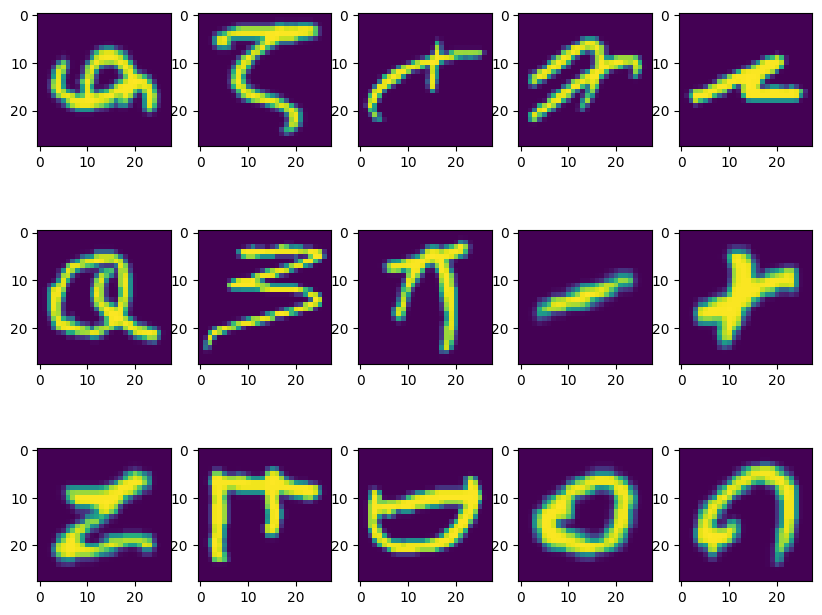

In [6]:
fig, axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i].reshape([28,28]))

In [7]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

x_train = np.apply_along_axis(rotate, 1, x_train)
x_test = np.apply_along_axis(rotate, 1, x_test)

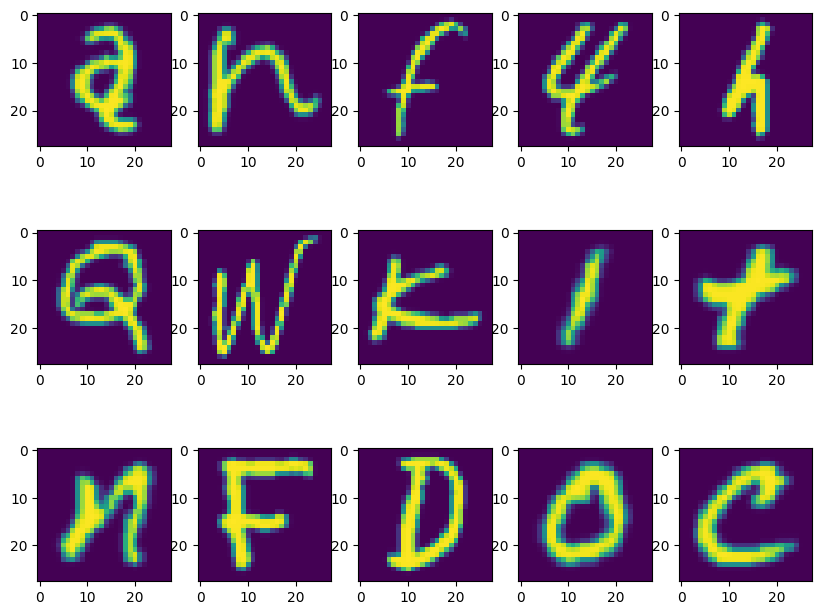

In [8]:
fig, axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i].reshape([28,28]))

In [9]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = tf.keras.utils.to_categorical(y_train, 47)
y_test = tf.keras.utils.to_categorical(y_test, 47)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input

# model = Sequential([
#     Input(shape=(28, 28, 1)),
#     Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(32, kernel_size=(3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.2),
#     Dense(128, activation='relu'),
#     Dropout(0.2),
#     Dense(47, activation='softmax')
#     # model = Sequential()
#     # Conv2D(32, kernel_size=3, activation='relu', input_shape=(rows, col, 1))
#     # MaxPooling2D()
#     # Conv2D(32, kernel_size=3, activation='relu')
#     # BatchNormalization()
#     # Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')
#     # BatchNormalization()
#     # Dropout(0.4)
#     # Conv2D(64, kernel_size=3, activation='relu')
#     # BatchNormalization()
#     # Conv2D(64, kernel_size=3, activation='relu')
#     # BatchNormalization()
#     # Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')
#     # BatchNormalization()
#     # Dropout(0.4)
#     # Flatten()
#     # Dropout(0.4)
#     # Dense(47, activation='softmax')
# ])
# model.summary()

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(32, (5, 5), activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(47, activation="softmax"))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 24, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 20, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 20, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 18, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 18, 18, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 9, 9, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,327,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 47)                  │          12,079 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,385,167 (5.28 MB)

 Trainable params: 1,384,783 (5.28 MB)

 Non-trainable params: 384 (1.50 KB)

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(x_train)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

In [14]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    epochs=20,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


882/882 ━━━━━━━━━━━━━━━━━━━━ 63s 59ms/step - accuracy: 0.6640 - loss: 1.1670 - val_accuracy: 0.8381 - val_loss: 0.4742
Epoch 2/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 67s 50ms/step - accuracy: 0.8374 - loss: 0.4680 - val_accuracy: 0.8615 - val_loss: 0.4099
Epoch 3/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.8558 - loss: 0.4066 - val_accuracy: 0.8638 - val_loss: 0.4004
Epoch 4/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.8632 - loss: 0.3749 - val_accuracy: 0.8752 - val_loss: 0.3520
Epoch 5/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 80s 50ms/step - accuracy: 0.8698 - loss: 0.3544 - val_accuracy: 0.8782 - val_loss: 0.3416
Epoch 6/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.8751 - loss: 0.3397 - val_accuracy: 0.8821 - val_loss: 0.3460
Epoch 7/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.8783 - loss: 0.3317 - val_accuracy: 0.8818 - val_loss: 0.3286
Epoch 8/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.8816 - loss: 0.3143 - val_accurac

In [15]:

accuracy = model.evaluate(x_test, y_test)[1]

print(f"Accuracy on test data: {accuracy}")


588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8934 - loss: 0.3097
Accuracy on test data: 0.8928666710853577


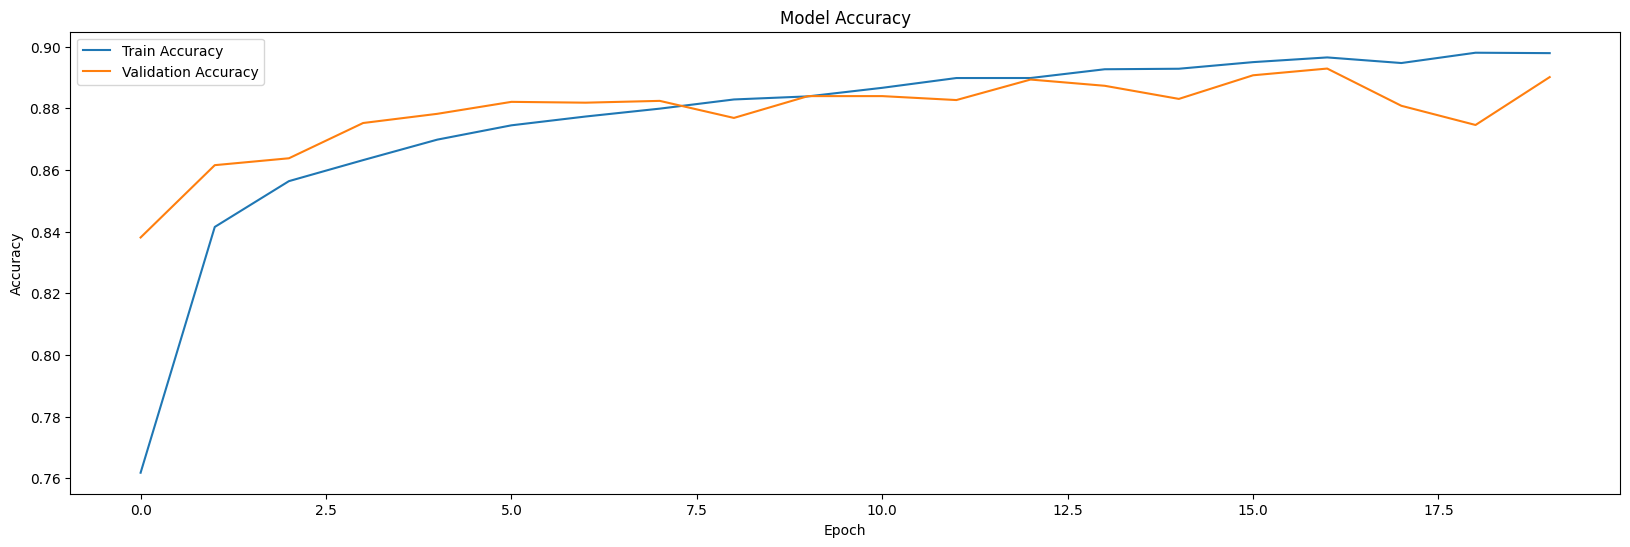

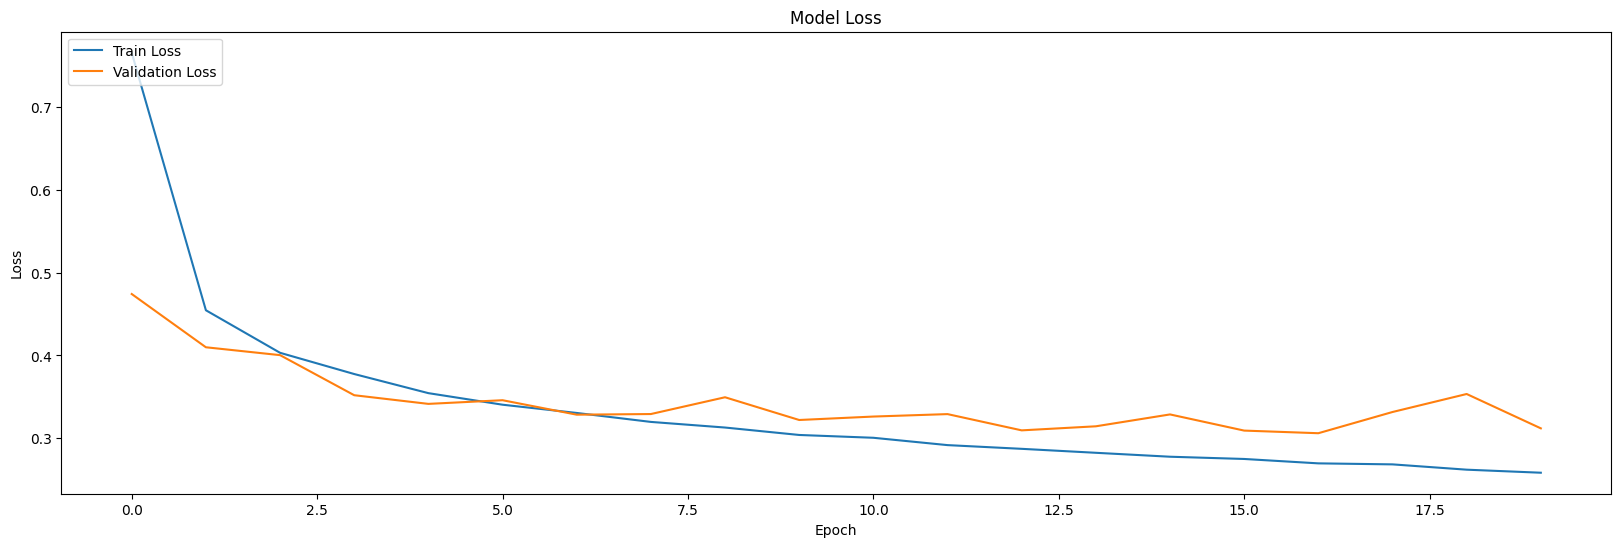

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(20, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(20, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [17]:
model.save('model-v0.8.keras')

In [18]:
import tensorflow.keras.models as models
model = models.load_model('model-v0.87.keras')

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   7  20  36  18   5   0
   0   5  32  37  37  32  20   1   0   0   0   0   0   0   0   0   0   0
   0   0   0   3  34  77 123  65  20   0   2  20 109 127 127 113  76   7
   0   0   0   0   0   0   0   0   0   0   1  20  34  84 175 220 247 168
  80   2  16  68 223 250 250 237 190  28   0   0   0   0   0   0   0   0
   2  11  36 158 202 233 252 254 247 157  76   2   6  32 162 246 253 238
 186  27   0   0   0   0   0   0   0   0  19  51  96 218 243 252 254 254
 234  95  34   0   1   8  91 221 247 246 210  46   0   0   0   0   0   0
   0   8 121 218 234 253 253 254 255 254 204  34   4   0   0   0  10 127
 206 250 245 128  10   1   0   0   0   0   4  32 203 253 254 237 205 225
 254 250 140   9   0   0   0   0   0  32  78 176 22

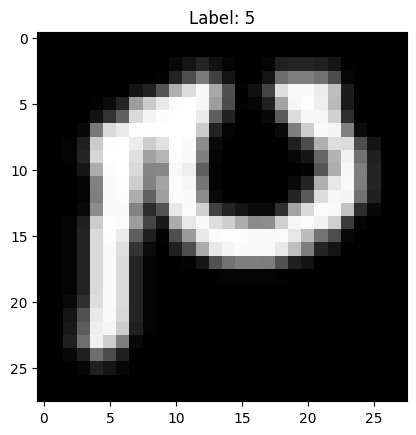

In [44]:
train_data = pd.read_csv('/kaggle/input/emnist-balanced-train.csv')

sample_index = 101
image = train_data.iloc[sample_index, 1:].values
label = train_data.iloc[sample_index, 0]

print(image)
image = image.reshape(28, 28)

plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [45]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

image1 = rotate(image)
# image1 = image1.reshape(-1, 28, 28, 1)

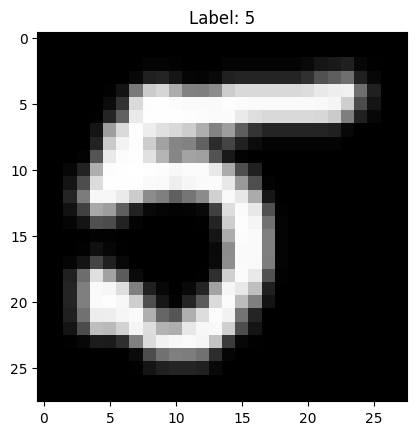

In [46]:
plt.imshow(image1, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [47]:
image1 = image1.reshape(-1, 28, 28, 1)
print(image1)
result = model.predict(image1)

[[[[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  4]
   [  4]
   [  2]
   [  0]
   [  0]
   [  0]
   [  4]
   [  4]
   [  4]
   [  4]
   [  4]
   [  4]
   [  9]
   [ 21]
   [ 25]
   [ 32]
   [  7]
   [  1]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  8]
   [ 32]
   [ 36]
   [ 21]
   [  5]
   [  4]
   [  9]
   [ 32]
   [ 37]
   [ 37]
   [ 37]
   [ 37]
   [ 37]
   [ 49]
   [ 82]
   [ 94]
   [111]
   [ 32]
   [  7]
   [

In [48]:
np.argmax(result)

5